In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from datetime import timedelta
import seaborn as sns
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import statsmodels.api as sm

from time import time

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\pmdarima\__init__.py:107: UserWarning: pmdarima support for 32-bit systems is ending with Python 3.10.Your system is not guaranteed to work going forward
  _warnings.warn(


## Datenbank einbinden
* Temperatursensor 1

In [2]:
connection = sql.connect("gcs_gh_10012022.db")

query_params = ['''SELECT * FROM s1_temp''']
df_temp1 = pd.read_sql_query(query_params[0], connection, parse_dates=['timestamp'], index_col=['timestamp'])

## Ausreißer behandeln
Ausreißer werden mit der Interquartile Range (IQR) herausgefiltert. Dabei werden Werte, die über dem 1.5-fachen des 0.75-Quantils (oberes Quantil) oder unter dem 1.5-fachen des 0.25-Quantils (unteres Quantil) liegen mit der unteren bzw. oberen Grenze des IQR ersetzt.

IQR: Datenpunkte werden nach der Größe sortiert und IQR gibt an, wie breit das Intervall ist, in dem 50% der Datenpunkte liegen

In [3]:
def outliers(s, replace=np.nan):
    Q1, Q3 = np.percentile(s, [25 ,75])
    IQR = Q3-Q1
    return s.where((s > (Q1 - 1.5 * IQR)) & (s < (Q3 + 1.5 * IQR)), replace)

In [4]:
df_temp1['month'] = df_temp1.index.month
df_temp1_clean = df_temp1.groupby('month')['value'].apply(outliers) #für jeden Monat Mittelwert einzeln berechnen (groupby month and year)
df_temp1_clean = pd.DataFrame(df_temp1_clean)
df_temp1_clean = df_temp1_clean.fillna(df_temp1_clean.groupby(df_temp1_clean.index.month).transform('mean'))

(0.0, 50.0)

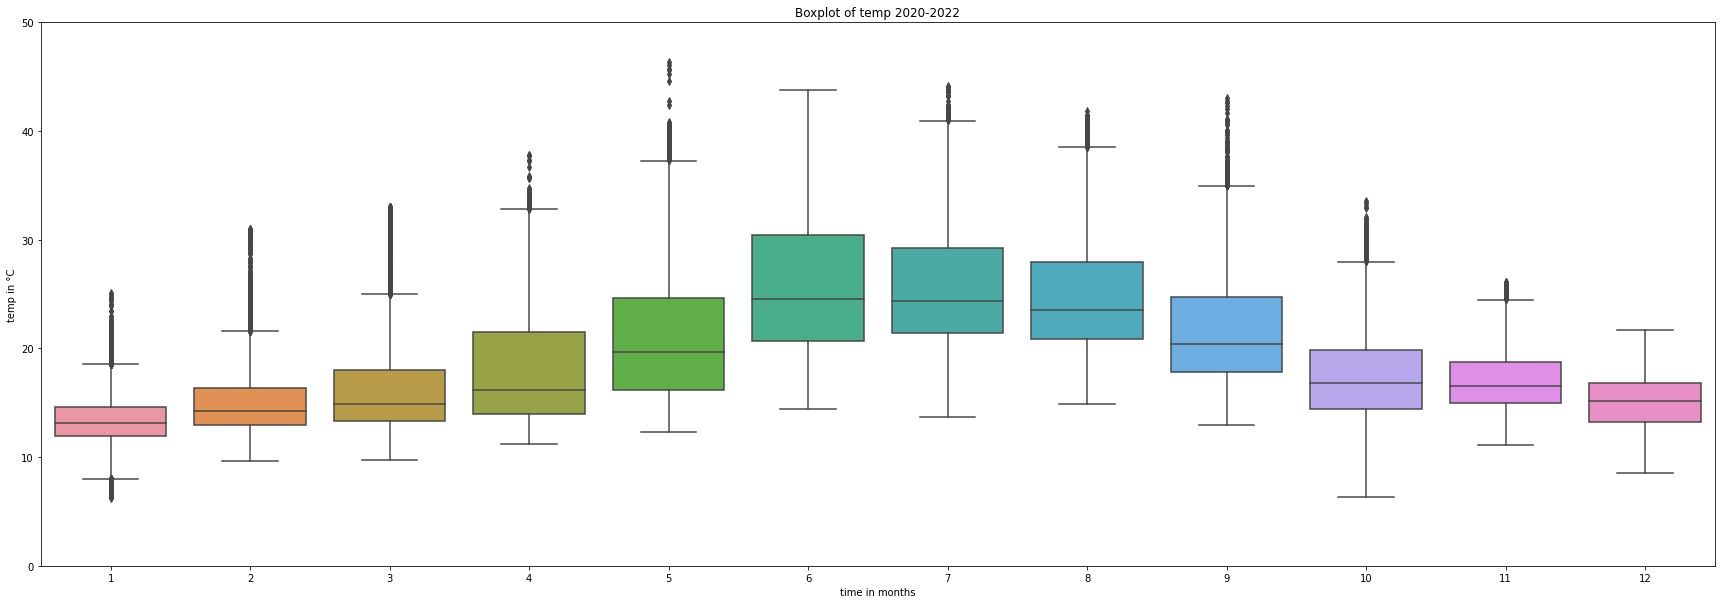

In [5]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.boxplot(data=df_temp1, x=df_temp1.index.month, y='value')
ax.set_title('Boxplot of temp 2020-2022')
ax.set_ylabel('temp in °C')
ax.set_xlabel('time in months')
ax.set_ylim(0, 50)

(0.0, 50.0)

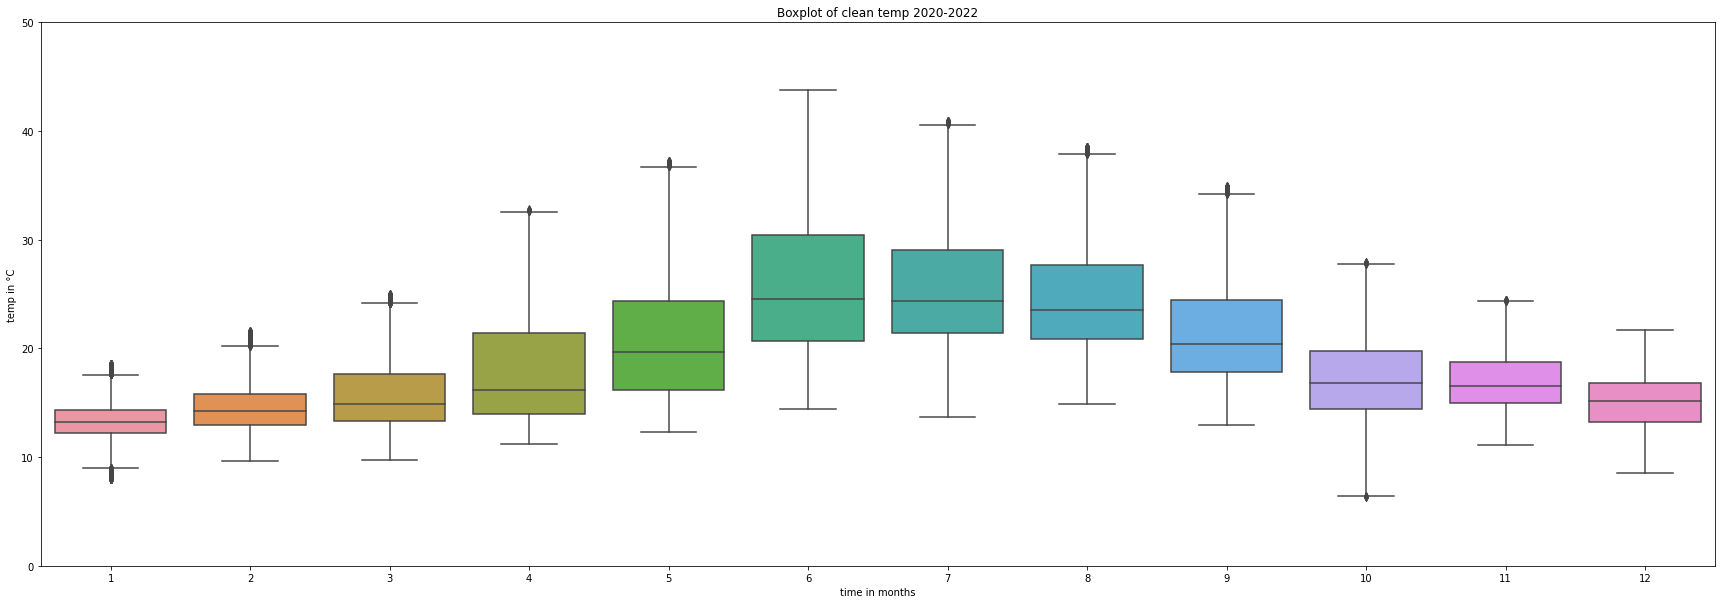

In [6]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.boxplot(data=df_temp1_clean, x=df_temp1_clean.index.month, y='value')
ax.set_title('Boxplot of clean temp 2020-2022')
ax.set_ylabel('temp in °C')
ax.set_xlabel('time in months')
ax.set_ylim(0, 50)

Entfernt und ersetzt werden die Ausreißer durch den Wert des oberen/unteren Quantils.

## Daten zusammenfassen

Die Temperaturdaten werden zu täglichen Temperaturdaten zusammengefasst und fehlende Werte durch einen forward-fill aufgefüllt.

In [7]:
font = {'size':25}
plt.rc('font', **font)

In [8]:
def dailyTempPlot(df_index, df_col, title):
    fig, ax = plt.subplots(figsize=(30, 10))
    ax.set_ylim(bottom=0, top=35)
    ax.set(xlabel="time",
           ylabel="temp in °C",
           title=title)
    plt.xticks(rotation=45)
    ax.scatter(df_index, df_col)

False
27


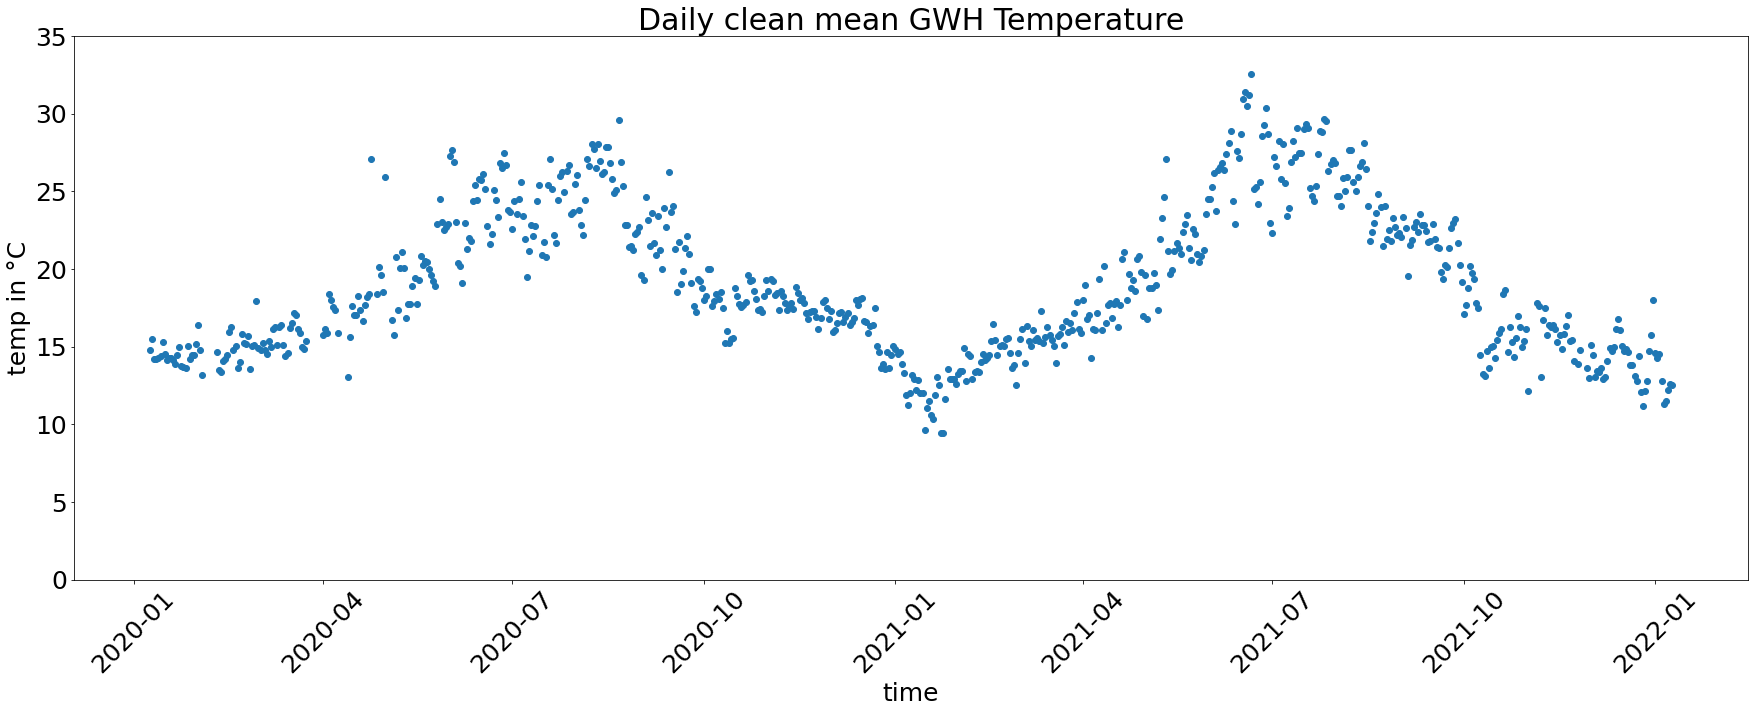

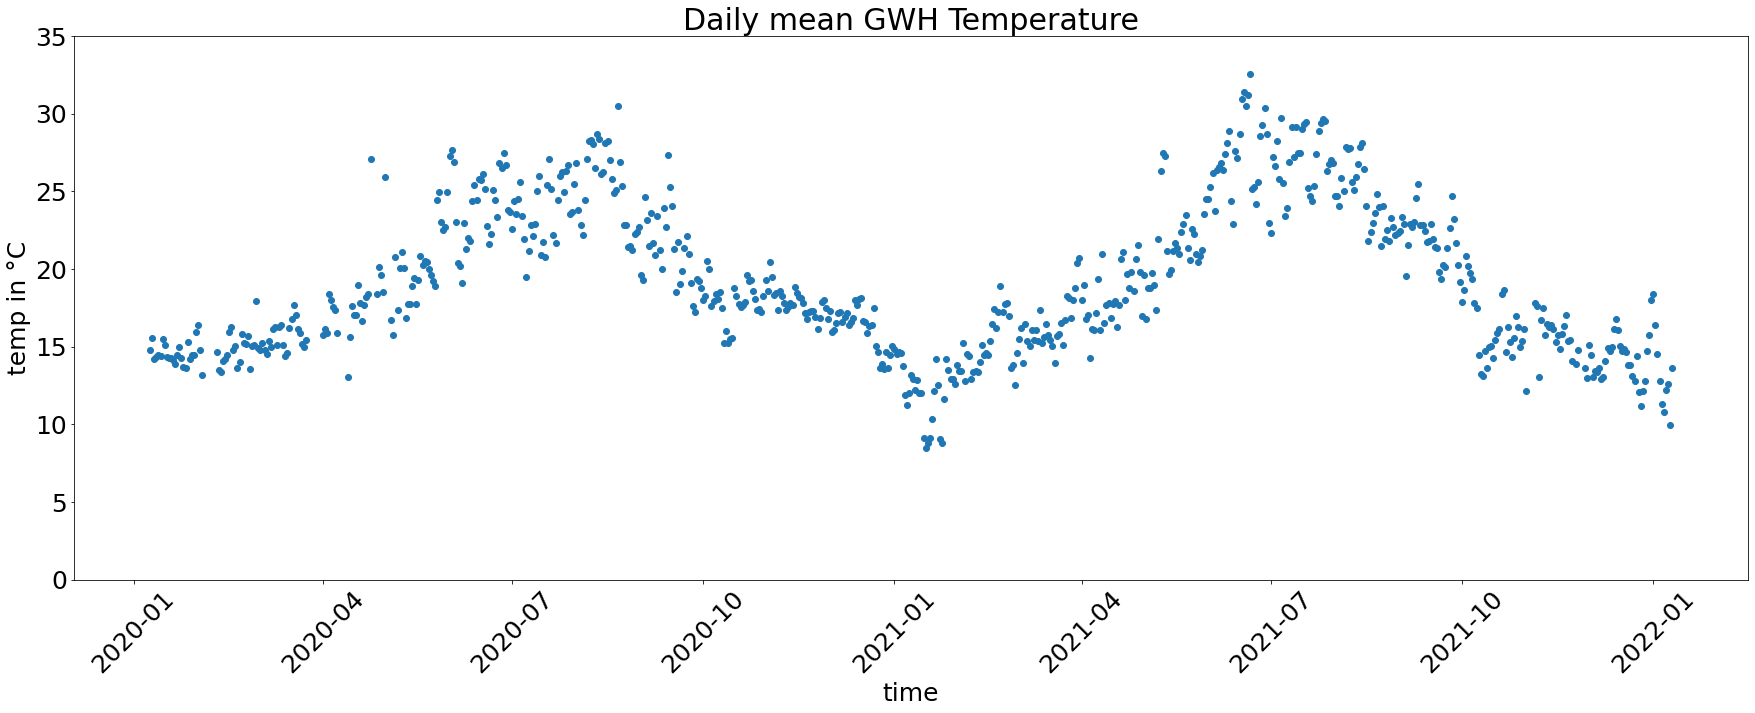

In [9]:
df_temp1_clean = df_temp1_clean.fillna(df_temp1_clean.groupby(df_temp1_clean.index.month).transform('mean'))
print(df_temp1_clean.isnull().values.any())

df_temp1_daily = df_temp1_clean.resample('D').mean()
print(df_temp1_daily.isnull().values.sum())


df_temp1_daily1 = df_temp1.resample('D').mean()


df_temp1_daily = df_temp1_daily.sort_index().loc['2020-01-09 ':'2022-01-09']
dailyTempPlot(df_temp1_daily.index, df_temp1_daily['value'], "Daily clean mean GWH Temperature")
dailyTempPlot(df_temp1_daily1.index, df_temp1_daily1['value'], "Daily mean GWH Temperature")

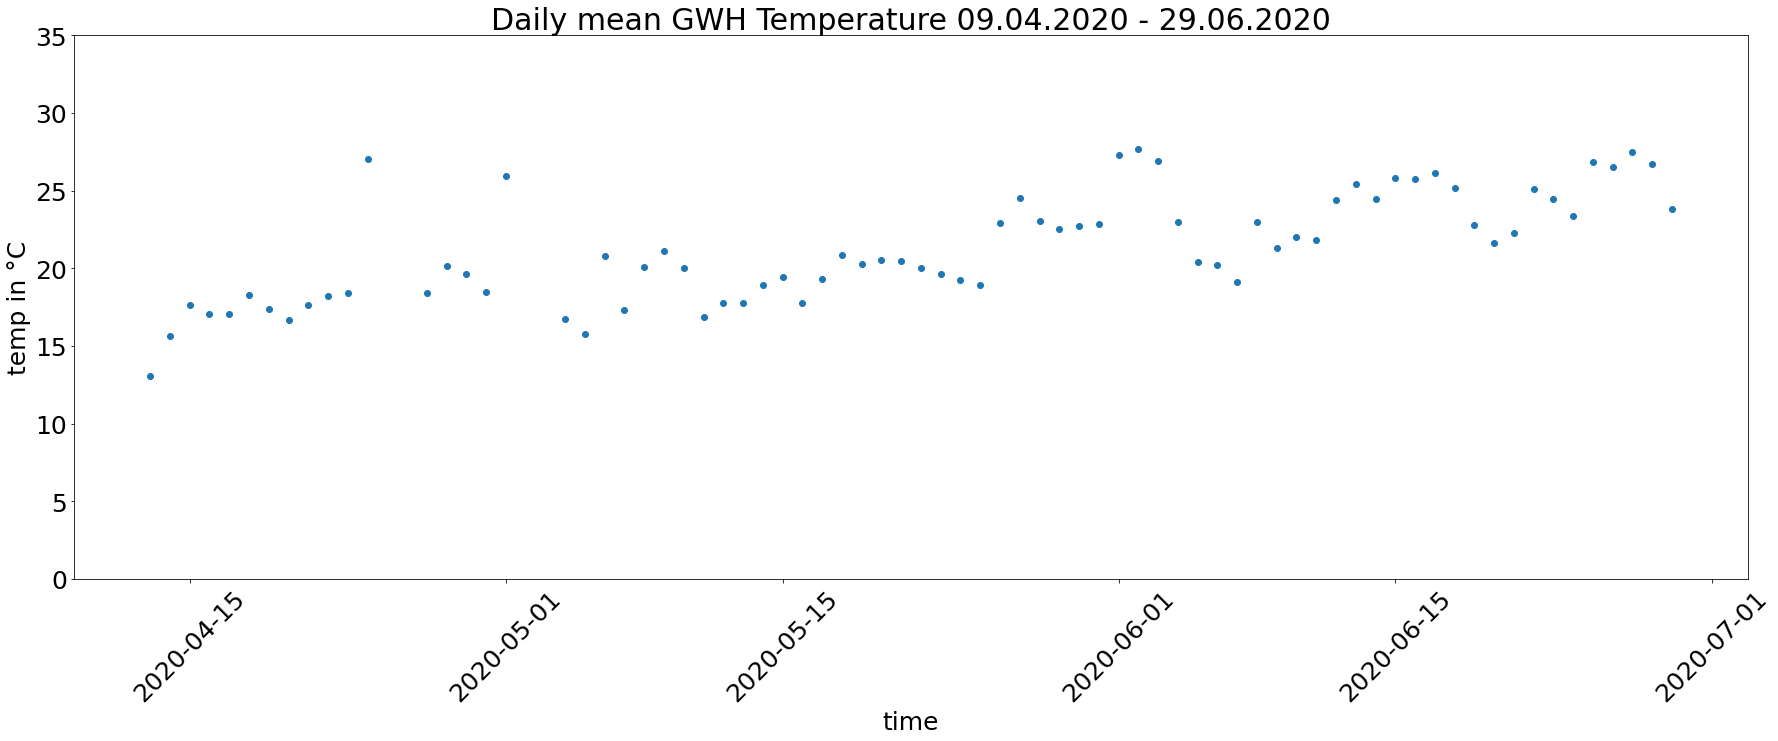

In [10]:
df_temp1_daily_excerpt = df_temp1_daily.sort_index().loc['2020-04-09 ':'2020-06-29']
dailyTempPlot(df_temp1_daily_excerpt.index, df_temp1_daily_excerpt['value'], "Daily mean GWH Temperature 09.04.2020 - 29.06.2020")

In [11]:
#Test, ob Ausreißer entfernen einen Unterschied macht
df_temp2_daily = df_temp1.resample('D').mean()
df_temp2_daily.isnull().values.any()
df_temp2_daily = df_temp2_daily.fillna(method='ffill')

df_temp2_daily = df_temp2_daily.sort_index().loc['2020-01-09 ':'2022-01-09']

print(df_temp2_daily.equals(df_temp1_daily))

False


## Stationarität
Die Stationarität wird von den Zeitreihenmodellen, die im Folgenden verwendet werden, vorausgesetzt. 

<b> Stationarität: </b>
* mittelwertstationär, konstanter Mittelwert μ
* varianzstationär, konstante Varianz σ
* kovarianzstationär

### Prüfen der Stationarität

<b>Visuelle Einschätzung:</b> <br>
Bei Betrachtung des täglichen Temperaturverlaufs fällt besonders die Saisonalität auf, die zu den inkonsistenten Mittelwerten und Varianzen führt 
* Mittelwert höher im Sommer, niedriger im Winter
* Varianz im Sommer höher als im Winter

In [12]:
font = {'size':15}
plt.rc('font', **font)

                value
timestamp            
2020-01-09  14.766511
2020-01-10  15.472202
2020-01-11  14.201580
2020-01-12  14.198678
2020-01-13  14.308615
...               ...
2022-01-05  11.344532
2022-01-06  11.531511
2022-01-07  12.221347
2022-01-08  12.589244
2022-01-09  12.554368

[732 rows x 1 columns]


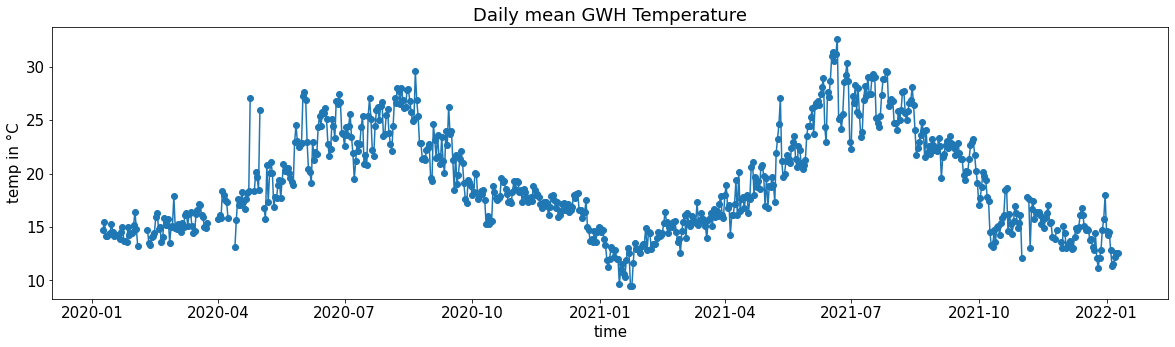

In [13]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_temp1_daily.index, df_temp1_daily['value'])
ax.plot(df_temp1_daily.index, df_temp1_daily['value'])
ax.set(xlabel="time",
       ylabel="temp in °C",
       title="Daily mean GWH Temperature")
print(df_temp1_daily)

<b>Statistischer Test:</b> <br>
Durch den Augmented-Dickey-Fuller-Test geprüft, ob die Tempereaturdaten stationär sind. <br>
<p>Nullhypothese H0: Φ => 1 → Einheitswurzel vorhanden, Zeitreihe ist nicht stationär <br>
Alternativhypothese H1: Φ < 1 → Zeitreihe ist stationär

Liegt der p-Wert unter der Schwelle von 5% (p < 0.05) kann mit 95% Sicherheit gesagt werden, dass die Zeitreihe stationär ist.

In [14]:
df_temp1_daily.isnull().values.any()
df_temp1_daily = df_temp1_daily.fillna(method='ffill')
series = df_temp1_daily['value'].values
result = adfuller(series)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -1.692833078269092
p-value: 0.43480882225840495
Critial Values:
   1%, -3.4394018678958544
Critial Values:
   5%, -2.865534780932388
Critial Values:
   10%, -2.5688972751486325


Da (p-Wert) 0.39 > (p-Wert Schwelle) 0.05 , wird die Nullhypothese angenommen. Die Zeitreihe ist nicht stationär. <br>

### Stationarität herstellen

Die Zeitreihe ist nicht stationär, weshalb sie in eine stationäre Form überführt werden muss. Dafür gitb es verschiedene Methoden, um die Trend- bzw. Saisonalkomponente zu entfernen.

1. Trend entfernen
    * Differenz bilden
    * Moving Average
2. Saisonalität entfernen
    * Moving Average
    * saisonale Struktur für die Differenzierung einsetzen

#### 1. Trend entfernen
* Differenz bilden

    Die Trendkomponente wird entfernt durch das Differenzieren. Dabei subtrahiert man von einem beobachteten Wert den vorherigen Wert.

[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Detrended GWH Temperature')]

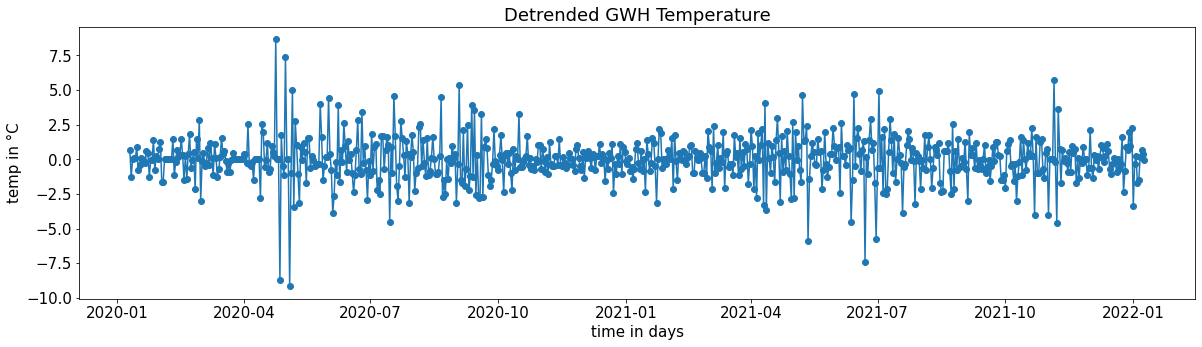

In [15]:
series_temp1_stationary_diff = df_temp1_daily['value'].diff(periods=1) # bei periods=365 ist das SARIMAX overfitted
df_temp1_detrend = pd.DataFrame(series_temp1_stationary_diff)
df_temp1_detrend.columns.values[0] = "value"

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_temp1_detrend.index, df_temp1_detrend['value'])
ax.scatter(df_temp1_detrend.index, df_temp1_detrend['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",
       title="Detrended GWH Temperature")

In [16]:
df_temp1_detrend = df_temp1_detrend.fillna(method='bfill')

series = df_temp1_detrend
result = adfuller(series)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -17.68982420821284
p-value: 3.576454104026352e-30
Critial Values:
   1%, -3.4393893552577723
Critial Values:
   5%, -2.8655292671104644
Critial Values:
   10%, -2.5688943376666744


Da (p-Wert) 4.73e-30 < (kritischer Wert 5%) 0.05, wird die Nullhyppthese abgelehnt. Die Zeitreihe ist stationär. 

<AxesSubplot:xlabel='timestamp'>

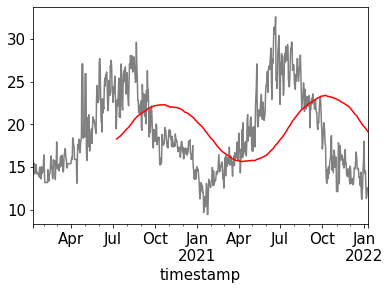

In [17]:
r = df_temp1_daily.rolling(window=183)
df_temp1_daily['value'].plot(color='gray')
r.mean()['value'].plot(color='red')

#### 2. Saisonalität entfernen

Im Folgenden wird der Detrended-Zeitreihe, die Saisonkomponente entfernt

1. Moving Average <br>
   
* Es werden die Tage eines Monats über die gesamte Zeitreihe gruppiert und der Mittelwert gebildet. Die so gebildeten Mittelwerte werden von den einzelnen Tagen der Zeitreihe abgezogen

                value  value daily mean  deseason_Temp
timestamp                                             
2020-01-09  14.766511         14.751431       0.015080
2020-01-10  15.472202         14.413585       1.058617
2020-01-11  14.201580         14.607183      -0.405603
2020-01-12  14.198678         13.338755       0.859923
2020-01-13  14.308615         12.336529       1.972086
...               ...               ...            ...
2022-01-05  11.344532         12.842929      -1.498397
2022-01-06  11.531511         13.737037      -2.205526
2022-01-07  12.221347         14.179319      -1.957972
2022-01-08  12.589244         15.116567      -2.527323
2022-01-09  12.554368         16.521788      -3.967419

[732 rows x 3 columns]


[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, "'De-Sesonalized' GWH Temperature")]

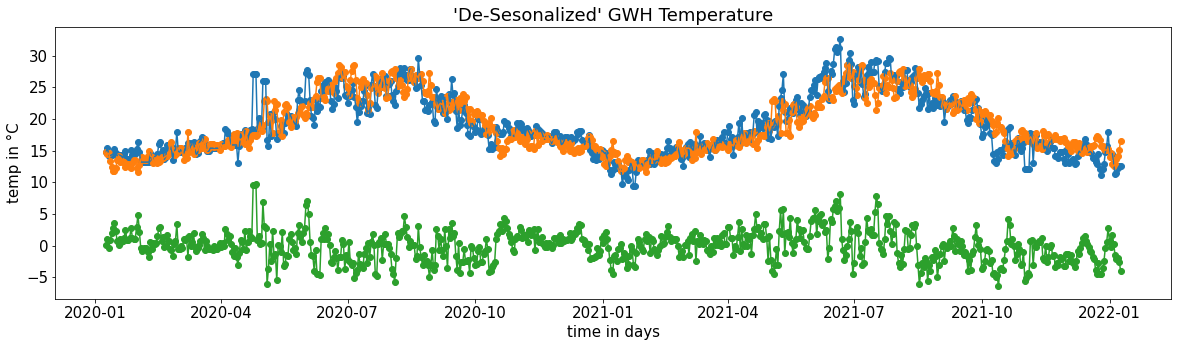

In [18]:
# Gruppierung in Monaten, dann Tagen: es wird der Durchschnitt eines Tages jeden Monats der Jahre berechnet
df_temp1_dailyMeans = df_temp1_daily.groupby([df_temp1_daily.index.month, df_temp1_daily.index.day])['value'].mean() 
df_temp1_dailyMeans = df_temp1_dailyMeans.to_frame()
df_temp1_dailyMeans = df_temp1_dailyMeans.reset_index(drop=True)

# Gleiches df_temp1_dailyMeans anhängen, um auf diesselbe Datenmenge zu kommen. Damit wird jeder Tag abgedeckt
df_temp1_dailyMeans = pd.concat([df_temp1_dailyMeans, df_temp1_dailyMeans], axis=0)

# Zeitstempel setzen und als Index setzen
df_temp1_dailyMeans['timestamp'] = pd.to_datetime(df_temp1_daily.index)
df_temp1_dailyMeans = df_temp1_dailyMeans.set_index('timestamp')

# Spalte umbenennen
df_temp1_dailyMeans.columns = ['value daily mean']

# df_temp1_dailyMeans und df_temp1_daily in ein df_ mergen, auf den Zeit-Index von df_temp1_daily
df_ = pd.merge(df_temp1_daily.sort_index(), df_temp1_dailyMeans.sort_index(), on="timestamp")
df_['deseason_Temp'] = df_['value'] - df_['value daily mean']
print(df_)

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_.index, df_['value'])
ax.scatter(df_.index, df_['value'])
ax.plot(df_.index, df_['value daily mean'])
ax.scatter(df_.index, df_['value daily mean'])
ax.plot(df_.index, df_['deseason_Temp'])
ax.scatter(df_.index, df_['deseason_Temp'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",
       title="'De-Sesonalized' GWH Temperature")

In [19]:
df_['deseason_Temp'].isnull().values.any()
df_['deseason_Temp'] = df_['deseason_Temp'].fillna(method='bfill')

series = df_['deseason_Temp']
result = adfuller(series, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -5.097884018362354
n_lags: 1.4156991720371153e-05
p-value: 1.4156991720371153e-05
Critial Values:
   1%, -3.439464954327953
Critial Values:
   5%, -2.8655625802683473
Critial Values:
   10%, -2.5689120852623457


Da 0.0003 >  0.05, wird die Nullhypothese abgelehnt. Die Zeitreihe ist stationär. 

Da das Differenzieren den kleinsten p-Wert hervorgebracht hat, wird mit dieser stationären Zeitreihe weitergearbeitet.

In [20]:
df_clean = df_temp1_detrend
# df_['deseason_Temp']
# df_temp1_detrend

## Dekompostion in Trend-, Saisonalitäts-, Restkomponente
Das Modul statsmodels stellt eine Methode zur Verfügung, bei der die Komponenten automatisch berechnet werden durch die Moving-Average-Methode.

Da kein steigender Trend und keine sich mit dem Trend veränderte Saisonalität oder Restkomponente feststellen lässt, wird angenommen, dass die Zeitreihe sich durch ein additives Model beschreiben lässt.

Eine Zeitreihe besteht somimt aus:  Trendkomponente + Saisonkomponente + Restkomponente → Yt = Tt + St + et

Es werden die Trend- und Saisonalkomponente von der ursprünglichen Zeitreihe abgezogen, sodass die Restkomponente zurückbleibt. Bei der Restkomponente handelt es sich um die stationäre Zeitreihe.

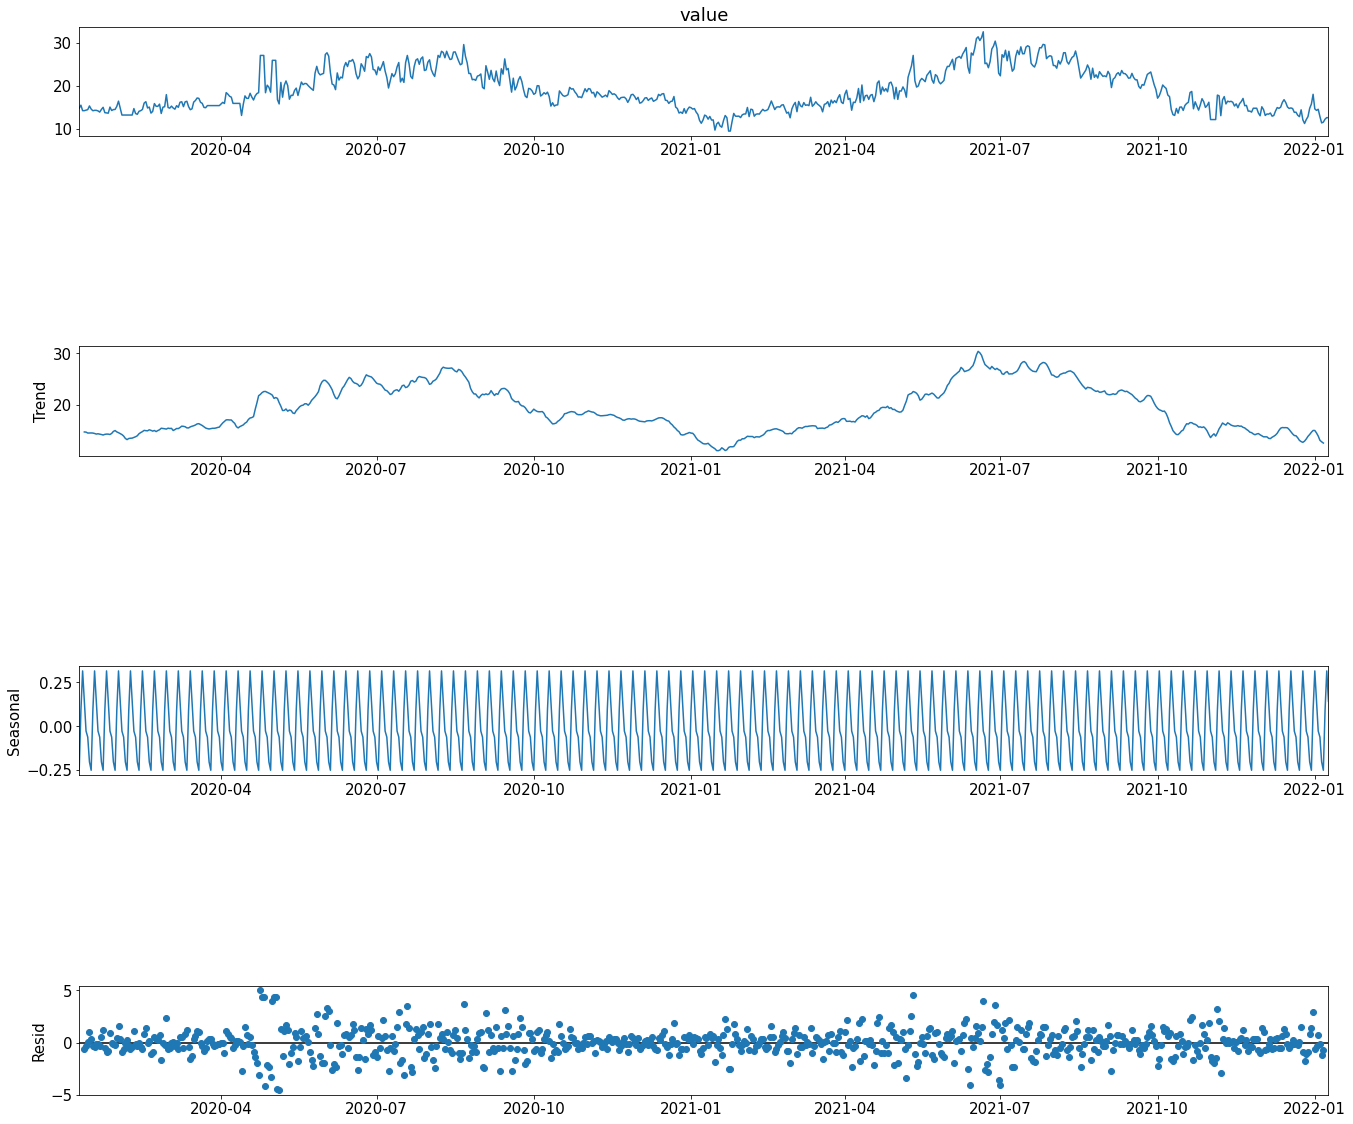

In [21]:
df_temp1_daily = df_temp1_daily.asfreq(pd.infer_freq(df_temp1_daily.index))
decomp_result = seasonal_decompose(df_temp1_daily['value'], model='additive')

trend = decomp_result.trend
periodic = decomp_result.seasonal
residual = decomp_result.resid

fig = decomp_result.plot()
fig.set_size_inches((25, 20))

Da die Saisonalität seltsam aussieht, wird sie für einen zufälligen Zeitraum geplotted. Vermutung: Trendkomponente enthält Saisonalitätskomponente. Da der Trend abgezogen wird, wird nicht diesselbe Saisonalitätskomponente herauskommen. Die Schwankungen zwischen -0.2 und 0.2°C sind gering, Saisonalität mit der Trend also schon zusammen abgezogen. 
Code --> wie sind Trend, Saisonalität definiert

               value
timestamp           
2020-01-09 -0.252564
2020-01-10  0.090899
2020-01-11  0.315782
2020-01-12  0.141594
2020-01-13 -0.028217
2020-01-14 -0.062871
2020-01-15 -0.204623
2020-01-16 -0.252564
2020-01-17  0.090899
2020-01-18  0.315782
2020-01-19  0.141594
2020-01-20 -0.028217
2020-01-21 -0.062871
2020-01-22 -0.204623
2020-01-23 -0.252564
2020-01-24  0.090899
2020-01-25  0.315782
2020-01-26  0.141594
2020-01-27 -0.028217
2020-01-28 -0.062871
2020-01-29 -0.204623
2020-01-30 -0.252564
2020-01-31  0.090899
2020-02-01  0.315782
2020-02-02  0.141594
2020-02-03 -0.028217
2020-02-04 -0.062871
2020-02-05 -0.204623
2020-02-06 -0.252564
2020-02-07  0.090899
2020-02-08  0.315782
2020-02-09  0.141594
2020-02-10 -0.028217
2020-02-11 -0.062871
2020-02-12 -0.204623
2020-02-13 -0.252564
2020-02-14  0.090899
2020-02-15  0.315782
2020-02-16  0.141594
2020-02-17 -0.028217
2020-02-18 -0.062871
2020-02-19 -0.204623
2020-02-20 -0.252564
2020-02-21  0.090899
2020-02-22  0.315782
2020-02-23  0

(-5.0, 35.0)

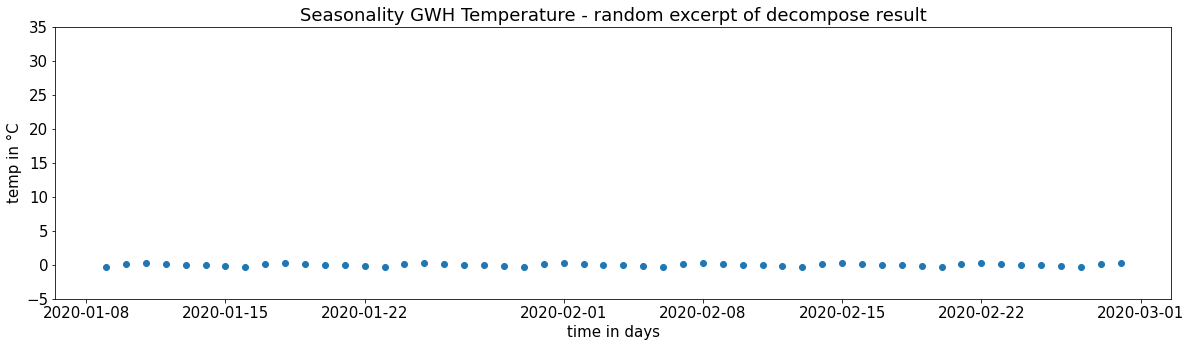

In [22]:
df = pd.DataFrame(periodic)
df.reset_index(inplace=True)
df.set_index('timestamp', inplace=True)
df.rename(columns={df.columns[0]:'value'}, inplace=True)
df_excerpt = df.sort_index().loc['2020-01-09':'2020-02']

print(df_excerpt)

fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_excerpt.index, df_excerpt['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",
       title="Seasonality GWH Temperature - random excerpt of decompose result")
ax.set_ylim(bottom=-5, top=35)

In [23]:
residual = residual.dropna()

result = adfuller(residual, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -12.533337066939426
p-value: 2.4016155435299764e-23
Critial Values:
   1%, -3.439606888036868
Critial Values:
   5%, -2.865625121924057
Critial Values:
   10%, -2.5689454046801052


In [24]:
# fig = sm.qqplot(residual, line='45')
# plt.show()

## Autocorrelation

### ACF und PACF mit stationären Daten

<b>ACF</b> 

Die ACF gibt an wie groß der Zusammenhang zwischen dem aktuellen Wert und vergangenen Werten ist. <br>
Aus dem ACF-Plot kann die Ordnung des MA-Modells geschätzt werden.

<b>ACF für tägliche Daten:</b>

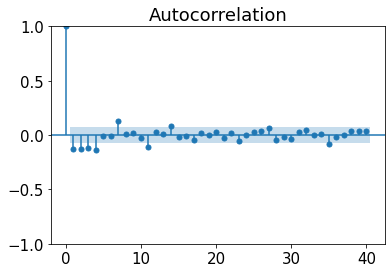

In [25]:
acf_result = stattools.acf(df_clean)
acf_plot_temp1_daily = tsaplots.plot_acf(df_clean, lags=40,bartlett_confint=False)

Ab einem Lag von 4 befindet sich die ACF innerhalb des Signifikanzbandes, d.h. die MA-Ordnung kann bis zu 4 betragen. 

<b>PACF</b> 

Die PACF gibt an wie groß der Zusammenhang zwischen Werten ist, die nicht durch die dazwischenliegenden Lags erklärt wird.<br>
Aus dem PACF-Plot kann die Ordnung des AR-Modells geschätzt werden

<b>PACF für tägliche Daten:</b>

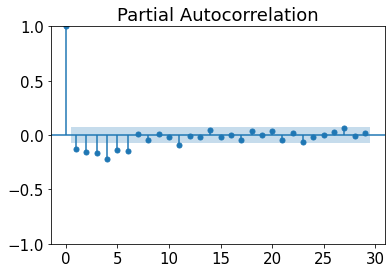

In [26]:
pacf_plot_temp1_daily = tsaplots.plot_pacf(df_clean,  method='ywm')

Ab einem Lag von 6 befindet sich die ACF innerhalb des Signifikanzbandes, d.h. die AR-Ordnung kann bis zu 6 betragen. 

## AR(I)MA-Modell

Das AR(I)MA-Modell ist wie folgt aufgebaut: AR(I)MA(p,d,q)

   * p: AR-Ordnung
   * d: Anzahl der Differenzierung
   * q: MA-Ordnung

In [27]:
# Frequenz der Zeitreihe wird festgelegt
df_clean = df_clean.asfreq(pd.infer_freq(df_clean.index))

In [45]:
# Für die Evaluation: Training-Set, Testing-Set bilden
train_end = datetime.datetime(2021,6,1)
test_end = datetime.datetime(2022,1,10)

train_data = df_clean[:train_end]
test_data = df_clean[train_end + timedelta(days=1):test_end]

In [46]:
# ARIMA-Model fitten, AR = 6, I =0, MA = 4
model = ARIMA(train_data, order=(6,0,4))
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time:', end - start)

# Zusammenfassung des Modells
print(model_fit.summary())

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model fitting time: 3.7993524074554443
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  510
Model:                 ARIMA(6, 0, 4)   Log Likelihood                -919.057
Date:                Mon, 16 May 2022   AIC                           1862.114
Time:                        23:50:00   BIC                           1912.927
Sample:                    01-09-2020   HQIC                          1882.036
                         - 06-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0172      0.028      0.618      0.536      -0.037       0.072
ar.L1         -1.0138      0.451     -2.248      0.025      -1.898      -0.130
ar.L2        

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
# Prediction Start und Ende festlegen
pred_start = datetime.datetime(2021,6,2)
pred_end = datetime.datetime(2022,1,10)

In [48]:
# Predictions und Reste, die das Modell nicht erklären konnte in einer Variablen speichern
predictions = model_fit.predict(start=pred_start, end=pred_end)
resid = test_data - predictions

Text(0, 0.5, 'temperature in °C')

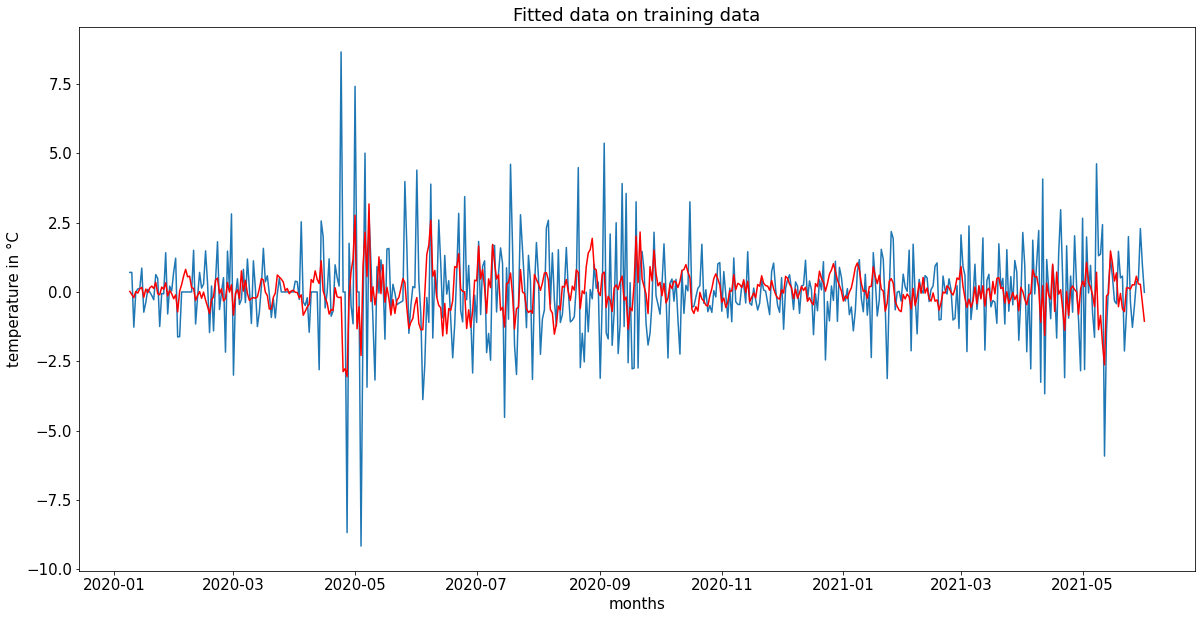

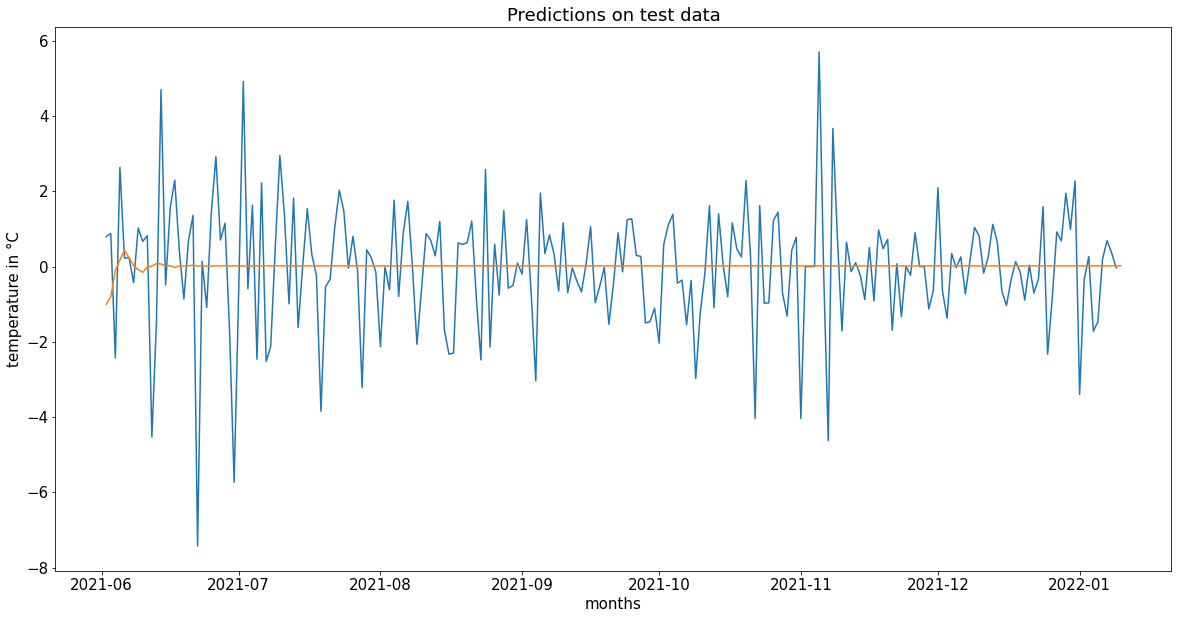

In [49]:
# Testdaten und dazugehörigen Predictions plotten
plt.figure(figsize=(20,10))
plt.plot(train_data)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('Fitted data on training data')
plt.xlabel('months')
plt.ylabel('temperature in °C')

plt.figure(figsize=(20,10))
plt.plot(test_data)
plt.plot(predictions)
plt.title('Predictions on test data')
plt.xlabel('months')
plt.ylabel('temperature in °C')

Modell ist nicht aussagekräftig. Gründe müssen untersucht werden.

### auto_arima()
Das Modul pmdarima bietet die Funktion auto_arima() an, bei der eine Range von Parametern für p,d,q angegeben werden kann und das beste Modell zurückgegeben wird mit dem höchsten Informationsgehalt nach AIC (Akaike-Informationskriterium. Weiterhin kann man Parameter für die Saisonalität angeben und somit ebenfalls ein SARIMA-Modell anpassen. <br>

Im folgenden wird ein SARIMA-Modell angepasst.

In [50]:
# SARIMA-Modell fitten
stepwise_fit = auto_arima(df_clean, start_p = 1, start_q = 1,
                            test='adf',
                            max_p = 6, max_q = 4, 
                            m= 7,
                            d=0,
                            seasonal=False,
                            start_P=0, start_Q=0,
                            D=0,
                            error_action='ignore',  # ignoriert Ordnungen, die nicht funktionieren
                            suppress_warnings=True,  # ignoriert Konvergenzwarnungen
                            stepwise=True)

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


In [51]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  732
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -1335.768
Date:                Mon, 16 May 2022   AIC                           2683.535
Time:                        23:50:10   BIC                           2711.110
Sample:                             0   HQIC                          2694.172
                                - 732                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3848      0.068      5.626      0.000       0.251       0.519
ar.L2         -0.1090      0.035     -3.098      0.002      -0.178      -0.040
ar.L3         -0.0962      0.032     -3.027      0.002      -0.158      -0.034
ar.L4         -0.1221      0.033     -3.663      0.000      -0.187      -0.057
ma.L1         -0.6489      0.059    -11.011      0.000      -0.764      -0.533
sigma2         2.2502      0.076     29.543      0.000       2.101       2.400
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               402.43
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.09
Prob(H) (two-sided):                  0.10   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

               value
timestamp           
2021-06-02  0.792198
2021-06-03  0.879513
2021-06-04 -2.428206
2021-06-05  2.631428
2021-06-06  0.223771
...              ...
2022-01-05 -1.464667
2022-01-06  0.186979
2022-01-07  0.689836
2022-01-08  0.367898
2022-01-09 -0.034876

[222 rows x 1 columns]


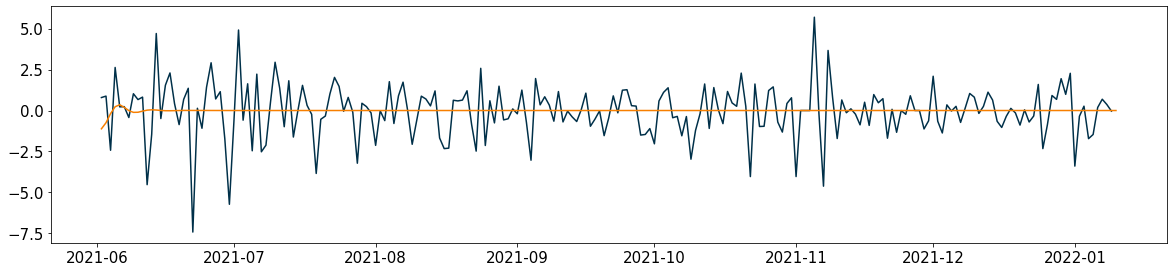

In [53]:
model = SARIMAX(train_data, order=(4,0,1), seasonal_order=(0,0,0,0))
model_fit = model.fit()
predictions = model_fit.predict(start=pred_start, end=pred_end)

plt.figure(figsize=(20,20))
plt.subplot(411)


plt.plot(test_data, label='Trend of time series',color='#003049')
plt.plot(predictions, label='Trend of time series',color='#f77f00')

print(test_data)

### ARIMA auf kleinere Zeitbereiche anwenden

## #1

In [36]:
train_end = datetime.datetime(2020,7,31) 
test_end = datetime.datetime(2020,8,31)

#'2020-06-01', '2020-08-31'

train_data = df_clean[:train_end]
test_data = df_clean[train_end + timedelta(days=1):test_end]
print(train_data)
print(test_data)

               value
timestamp           
2020-01-09  0.705691
2020-01-10  0.705691
2020-01-11 -1.270622
2020-01-12 -0.002901
2020-01-13  0.109937
...              ...
2020-07-27  1.321634
2020-07-28  0.400053
2020-07-29 -3.158824
2020-07-30  0.140188
2020-07-31  1.784152

[205 rows x 1 columns]
               value
timestamp           
2020-08-01  0.566550
2020-08-02 -2.251830
2020-08-03 -0.976879
2020-08-04 -0.649026
2020-08-05  2.311192
2020-08-06  2.587901
2020-08-07 -0.447627
2020-08-08  1.411958
2020-08-09 -0.280843
2020-08-10 -1.233834
2020-08-11  1.523954
2020-08-12 -1.100855
2020-08-13 -0.821105
2020-08-14  0.113849
2020-08-15  1.605803
2020-08-16  0.049912
2020-08-17 -1.082125
2020-08-18 -1.020090
2020-08-19 -0.892533
2020-08-20  0.218545
2020-08-21  4.489261
2020-08-22 -2.729713
2020-08-23 -1.489277
2020-08-24 -2.523197
2020-08-25 -0.006303
2020-08-26 -1.439337
2020-08-27  0.087819
2020-08-28 -0.249492
2020-08-29  0.999727
2020-08-30  0.132408
2020-08-31  0.356202


In [37]:
# ARIMA-Model fitten, AR = 6, I =0, MA = 4
model1 = ARIMA(train_data, order=(6,0,4))
start = time()
model_fit1 = model1.fit()
end = time()
print('Model fitting time:', end - start)

# Zusammenfassung des Modells
print(model_fit.summary())

Model fitting time: 1.440891981124878
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  732
Model:               SARIMAX(6, 0, 4)   Log Likelihood               -1332.157
Date:                Mon, 16 May 2022   AIC                           2686.315
Time:                        23:36:04   BIC                           2736.868
Sample:                    01-09-2020   HQIC                          2705.816
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9818      0.308     -3.192      0.001      -1.585      -0.379
ar.L2         -0.3366      0.349     -0.965      0.335      -1.020       0.347
ar.L3         

In [38]:
pred_start = datetime.datetime(2020,8,1)
pred_end = datetime.datetime(2020,8,31)

In [39]:
predictions2 = model_fit1.predict(start=pred_start, end=pred_end)

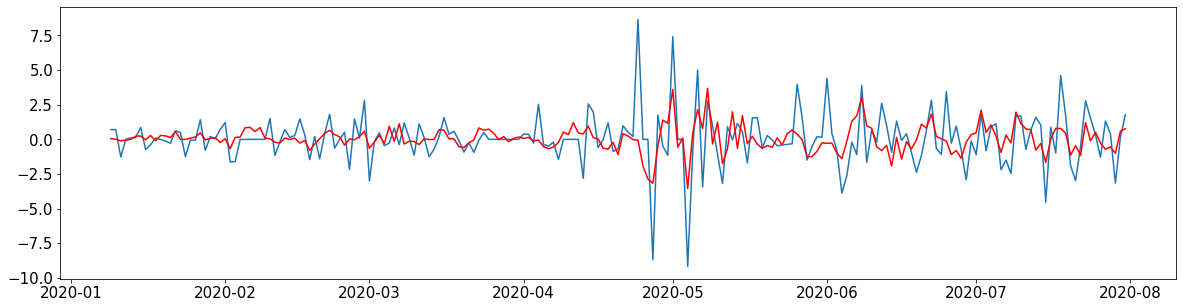

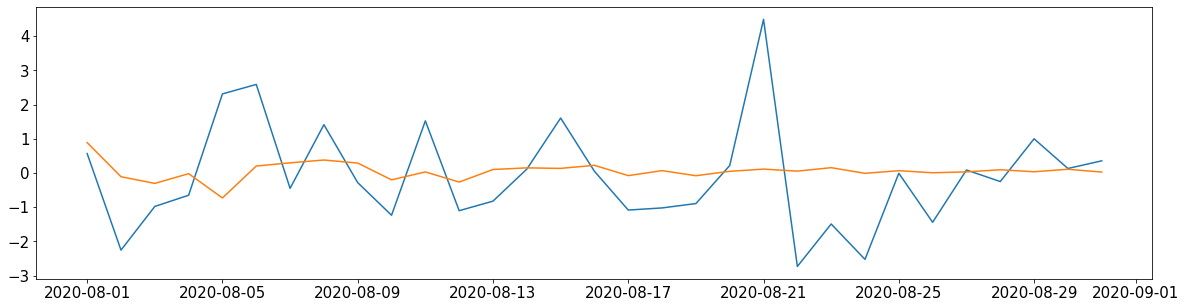

In [40]:
plt.figure(figsize=(20,5))
plt.plot(train_data)
plt.plot(model_fit1.fittedvalues, color='red')

plt.figure(figsize=(20,5))
# plt.plot(train_data)
plt.plot(test_data)
plt.plot(predictions2)

## #2

In [41]:
# ARIMA-Model fitten, AR = 6, I =0, MA = 4
model1 = ARIMA(train_data, order=(6,0,4))
start = time()
model3_fit = model1.fit()
end = time()
print('Model fitting time:', end - start)

# Zusammenfassung des Modells
print(model_fit.summary())

Model fitting time: 1.6481430530548096
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  732
Model:               SARIMAX(6, 0, 4)   Log Likelihood               -1332.157
Date:                Mon, 16 May 2022   AIC                           2686.315
Time:                        23:36:07   BIC                           2736.868
Sample:                    01-09-2020   HQIC                          2705.816
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9818      0.308     -3.192      0.001      -1.585      -0.379
ar.L2         -0.3366      0.349     -0.965      0.335      -1.020       0.347
ar.L3        

In [42]:
pred_start = datetime.datetime(2020,8,1)
pred_end = datetime.datetime(2020,8,5)

In [43]:
predictions3 = model3_fit.predict(start=pred_start, end=pred_end)